### Dataset loader for the deep learning model training.

In [1]:
import torch
from glob import glob
import rasterio as rio
import numpy as np 
import random
from utils.imgShow import imsShow


In [2]:
# ----------Data paths-------------- 
paths_truth = sorted(glob('data/dset-l5789/truth/*.tif'))
paths_scene = [path_truth.replace('_truth.tif', '.tif').replace('truth','scene') 
                                                        for path_truth in paths_truth]
print(len(paths_scene))


76


In [3]:
## create related functions
## - crop scene to patches
class crop:
    '''randomly crop corresponding to specific patch size'''
    def __init__(self, size=(256,256)):
        self.size = size
    def __call__(self, image, truth):
        '''size: (height, width)'''
        start_h = random.randint(0, truth.shape[0]-self.size[0])
        start_w = random.randint(0, truth.shape[1]-self.size[1])
        patch = image[:,start_h:start_h+self.size[0],start_w:start_w+self.size[1]]
        truth = truth[start_h:start_h+self.size[0], start_w:start_w+self.size[1]]
        return patch, truth

### - Dataset definition
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths_scene, paths_truth):
        self.paths_scene = paths_scene
        self.paths_truth = paths_truth

    def __getitem__(self, idx):
        # load pairwise scene and truth images
        scene_path = self.paths_scene[idx]
        truth_path = self.paths_truth[idx]
        with rio.open(scene_path) as src, rio.open(truth_path) as truth_src:
            scene_arr = src.read().transpose((1, 2, 0))  # (H, W, C)
            truth_arr = truth_src.read(1)  # (H, W)
        ## Pre-processing
        scene_arr = scene_arr/10000  # normalization
        scene_arr = scene_arr.astype(np.float32).transpose((2, 0, 1))
        patch, truth = crop(size=(256,256))(scene_arr, truth_arr)
        truth = truth[np.newaxis,:].astype(np.float32)
        patch = torch.from_numpy(patch).float()
        truth = torch.from_numpy(truth).float()
        return patch, truth
    def __len__(self):
        return len(self.paths_scene)




In [4]:
## Create dataset instances
tra_data = Dataset(paths_scene=paths_scene, paths_truth=paths_truth)
val_data = Dataset(paths_scene=paths_scene, paths_truth=paths_truth)


torch.Size([6, 256, 256]) torch.Size([1, 256, 256])
training data size: 76
validation data size: 76


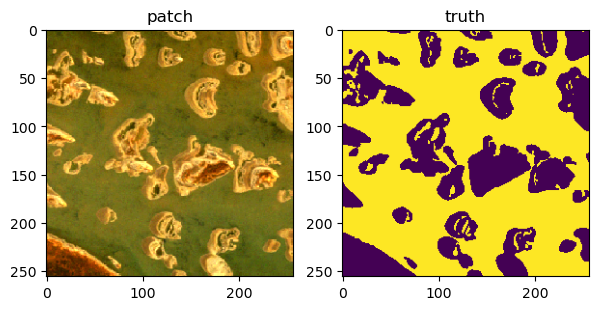

In [5]:
patch, truth = tra_data[0]
print(patch.shape, truth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([patch.numpy().transpose((1, 2, 0)), truth[0].numpy()], 
                        img_name_list=['patch', 'truth'], figsize=(7, 4))


In [6]:
### Create DataLoader
tra_loader = torch.utils.data.DataLoader(tra_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)


torch.Size([4, 6, 256, 256]) torch.Size([4, 1, 256, 256])


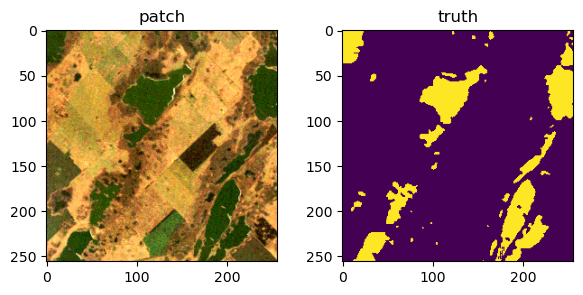

In [7]:
# for patch, truth in tra_loader:
#     print(patch.shape)
batch_patch, batch_truth = next(iter(tra_loader))
print(batch_patch.shape, batch_truth.shape)
patch_arr = batch_patch[0].numpy().transpose((1, 2, 0))
truth_arr = batch_truth[0].numpy().squeeze()
imsShow([patch_arr, truth_arr], img_name_list=['patch', 'truth'], figsize=(7, 3))
